In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
import optuna


from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve, 
    confusion_matrix,
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    auc
)

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

In [3]:
train_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
train_data.describe(percentiles = (np.arange(0, 1, 0.1)))

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
0%,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
10%,5864.400000,22.000000,3.120000e+04,0.000000,3000.000000,6.760000,0.060000,2.000000,0.000000
20%,11728.800000,23.000000,3.948000e+04,1.000000,5000.000000,7.510000,0.080000,3.000000,0.000000
30%,17593.200000,24.000000,4.500000e+04,2.000000,5600.000000,8.000000,0.100000,3.000000,0.000000
40%,23457.600000,25.000000,5.000000e+04,3.000000,7000.000000,9.990000,0.120000,4.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000


In [5]:
train_data.dtypes

id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

In [6]:
train_data.isna().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [7]:
# target distribution
train_data['loan_status'].value_counts(normalize=True)

loan_status
0    0.857618
1    0.142382
Name: proportion, dtype: float64

In [8]:
features_list = list(train_data.drop(['id', 'loan_status'], axis = 1).columns)
num_features = train_data[features_list].select_dtypes(include=['number']).columns.to_list()
cat_features = train_data[features_list].select_dtypes(include=['object']).columns.to_list()

## Feature Selection

In [9]:
def const_feature(df, features_lst, N):
    """
        Function for deleting const features
        Parameters:
            df: pd.Dataframe
            features_lst: list
               list of features
            N: float
                The percentage for a constant value in the sample
    """
    features_list = features_lst.copy()
    
    # list for const features
    wrong_features = list()
    for feature in features_list:
        # calculate the share of the maximum value in the feature from the total
        # if the share is greater than N, add the feature to the list for deletion
        if (df[feature].value_counts().head(1).unique() / df.shape[0]) > N:
            wrong_features.append(feature)

    return wrong_features

In [10]:
print('List of const features: ',  const_feature(train_data, features_list, 0.9))

List of const features:  []


In [11]:
def remove_low_variance_features(df, features, threshold=0.1):
    
    variance = df[features].var()
    # determine features with a variance below the threshold
    low_variance_features = variance[variance < threshold].index
    return low_variance_features

In [12]:
print('Фичи с низкой дисперсией: ', remove_low_variance_features(train_data, num_features, threshold=0.1))

Фичи с низкой дисперсией:  Index(['loan_percent_income'], dtype='object')


In [13]:
features_list = list(set(features_list) - set('loan_percent_income'))

<Axes: >

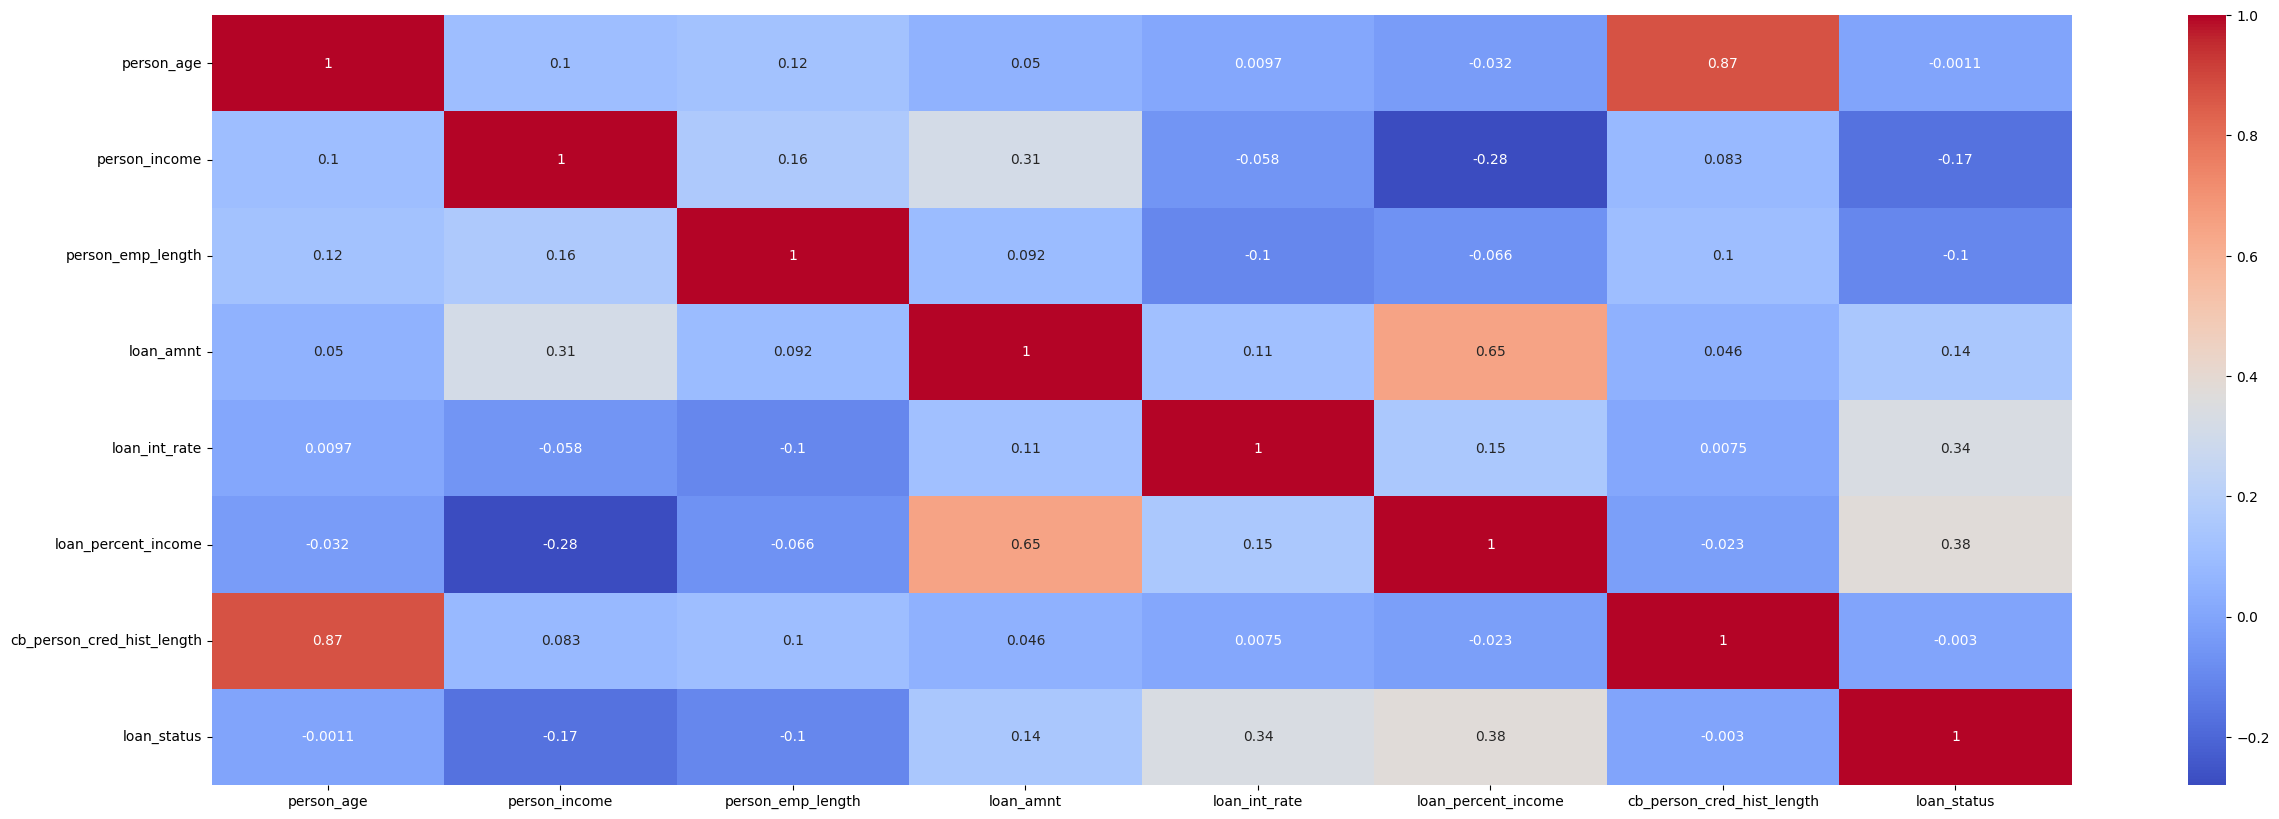

In [14]:
plt.figure(figsize=(30, 10))
sns.heatmap(train_data[num_features + ['loan_status']].abs().corr(), annot = True, cmap= 'coolwarm')

## Splitting data into train and valid set

In [15]:
X = train_data[num_features + cat_features]
y = train_data['loan_status']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.3, random_state = 42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, stratify=y_valid, test_size=0.2, random_state = 42)

In [16]:
print('Train size: ', X_train.shape[0])
print('Valid size: ',  X_valid.shape[0])
print('Test size: ',  X_test.shape[0])

Train size:  41051
Valid size:  14075
Test size:  3519


In [17]:
print('Train target: ')
print(y_train.value_counts(normalize=True))
print('Valid target: ')
print(y_valid.value_counts(normalize=True))
print('Test target: ')
print(y_test.value_counts(normalize=True))

Train target: 
loan_status
0    0.857616
1    0.142384
Name: proportion, dtype: float64
Valid target: 
loan_status
0    0.85762
1    0.14238
Name: proportion, dtype: float64
Test target: 
loan_status
0    0.85763
1    0.14237
Name: proportion, dtype: float64


In [18]:
X_build = pd.concat([X_train, X_valid], axis = 0)
y_build = pd.concat([y_train, y_valid], axis = 0)

## Modeling

In [19]:
def find_feature_importance_catboost(X_train, y_train, cat_features, model):
    
    pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
    
    importance = pd.DataFrame({
        'features': X_train.columns,
        'importance': model.get_feature_importance(pool)
    })
    importance = importance.sort_values(by='importance', ascending = False)
    
    plt.figure(figsize=(20, 8))
    sns.barplot(y = importance['features'], x = importance['importance'])
    plt.show()
    plt.close()

In [20]:
def find_best_threshold(X_build, y_build, clf):
    
    y_pred_proba = clf.predict_proba(X_build)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_build,  y_pred_proba)  
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores, nan=0.0)
    optimal_threshold = round(thresholds[np.argmax(f1_scores)], 2)
    
    y_pred_binary = [1 if k >= optimal_threshold else 0 for k in y_pred_proba]
    
    return optimal_threshold

In [21]:
model = CatBoostClassifier(
    iterations=2000,
    learning_rate = 0.15,
    depth = 4,
    grow_policy= 'Lossguide',
    loss_function='Logloss',
    eval_metric='AUC',
    auto_class_weights='Balanced',
    early_stopping_rounds=100,
    cat_features=cat_features,
    use_best_model = True,
    random_seed=42             
)

model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=100)

0:	test: 0.8773466	best: 0.8773466 (0)	total: 91.1ms	remaining: 3m 2s
100:	test: 0.9497994	best: 0.9497994 (100)	total: 2.81s	remaining: 52.8s
200:	test: 0.9546362	best: 0.9546463 (195)	total: 5.55s	remaining: 49.7s
300:	test: 0.9564527	best: 0.9564717 (299)	total: 8.31s	remaining: 46.9s
400:	test: 0.9565448	best: 0.9569213 (379)	total: 11s	remaining: 43.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9569213408
bestIteration = 379

Shrink model to first 380 iterations.


In [22]:
0.9556067221

0.1 - 0.9564463567
depth=4 - 0.9575421686

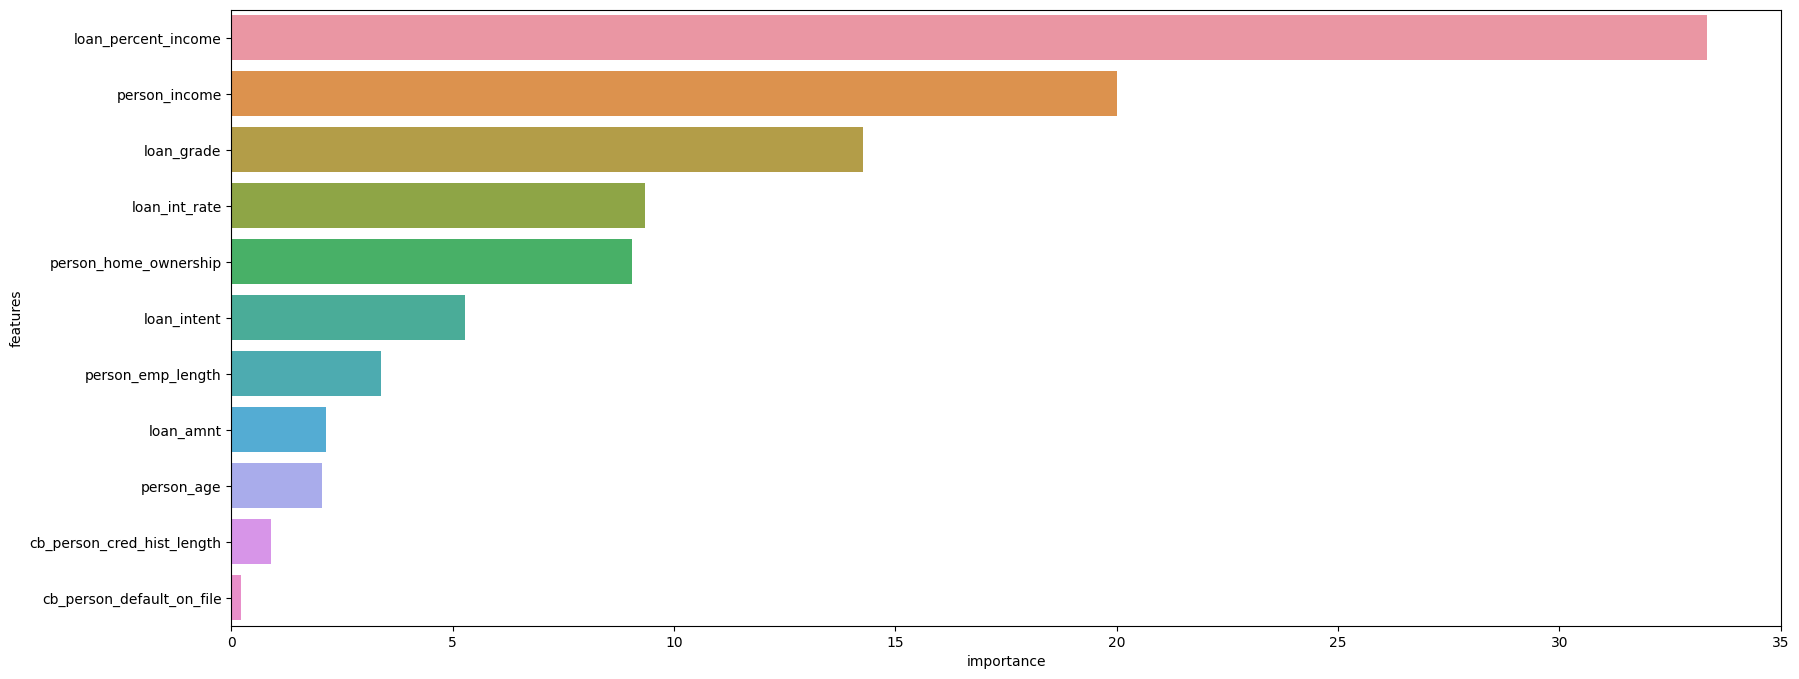

In [23]:
find_feature_importance_catboost(X_train, y_train, cat_features, model)

In [24]:
model_threshold = find_best_threshold(X_build, y_build, model)
print('Optimal threshold: ', model_threshold)

Optimal threshold:  0.67


In [25]:
# Evaluation of the deferred test sample
predictions = model.predict(X_test)
predictions_proba = model.predict_proba(X_test)[:, 1]
predictions = [1 if k >= model_threshold else 0 for k in predictions_proba]

print('Accuracy score: ', accuracy_score(predictions, y_test))
print('Recall score: ', recall_score(predictions, y_test))
print('Precision score: ', precision_score(predictions, y_test))
print('ROC-AUC score: ', roc_auc_score(y_test, predictions_proba))

Accuracy score:  0.9474282466609832
Recall score:  0.8251028806584362
Precision score:  0.8003992015968064
ROC-AUC score:  0.9558999958995198


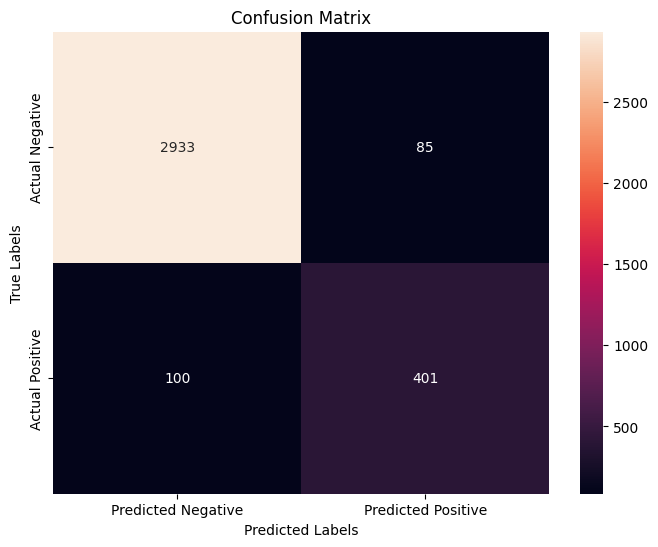

In [26]:
# Calculating confusion matrix
cm = confusion_matrix(y_test, predictions)

# visualisation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Optuna

In [27]:
# Создаем функцию для Optuna, которая оптимизирует гиперпараметры модели
def objective(trial):
    # Определяем пространство поиска гиперпараметров
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'verbose': 0
    }

    # Инициализируем и обучаем модель CatBoostClassifier с текущими гиперпараметрами
    model = CatBoostClassifier(**params, 
                               loss_function='Logloss',
                               eval_metric='AUC',
                               auto_class_weights='Balanced', 
                               random_state=42,
                               cat_features=cat_features)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=100, early_stopping_rounds=50)
    
    # Предсказания вероятностей положительного класса
    preds_proba = model.predict_proba(X_valid)[:, 1]
    # Вычисляем значение метрики ROC AUC
    roc_auc = roc_auc_score(y_valid, preds_proba)
    
    # Оптимизируем метрику accuracy
    return roc_auc

# Запускаем оптимизацию с помощью Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Количество итераций оптимизации

# Получаем лучшие гиперпараметры
best_params = study.best_params
print("Лучшие параметры:", best_params)

[I 2024-10-28 19:37:43,554] A new study created in memory with name: no-name-95dd1d03-acfc-48e5-a20a-264c2282846c


0:	test: 0.8857855	best: 0.8857855 (0)	total: 60.6ms	remaining: 24.8s
100:	test: 0.9470065	best: 0.9483739 (80)	total: 4.87s	remaining: 15s


[I 2024-10-28 19:37:50,376] Trial 0 finished with value: 0.9483739008603621 and parameters: {'iterations': 411, 'depth': 9, 'learning_rate': 0.2641299698848961, 'l2_leaf_reg': 3.6691825323466816, 'border_count': 146, 'random_strength': 6.672951013836848, 'bagging_temperature': 0.9029095110764823}. Best is trial 0 with value: 0.9483739008603621.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9483739009
bestIteration = 80

Shrink model to first 81 iterations.
0:	test: 0.9063052	best: 0.9063052 (0)	total: 89.1ms	remaining: 44s
100:	test: 0.9406571	best: 0.9408330 (95)	total: 5.3s	remaining: 20.6s
200:	test: 0.9481275	best: 0.9485029 (186)	total: 13.3s	remaining: 19.4s


[I 2024-10-28 19:38:06,709] Trial 1 finished with value: 0.948502919601936 and parameters: {'iterations': 494, 'depth': 10, 'learning_rate': 0.11667605439373052, 'l2_leaf_reg': 2.856648447000653, 'border_count': 107, 'random_strength': 1.8405257523853913, 'bagging_temperature': 0.390111598277326}. Best is trial 1 with value: 0.948502919601936.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9485029196
bestIteration = 186

Shrink model to first 187 iterations.
0:	test: 0.8825860	best: 0.8825860 (0)	total: 12.8ms	remaining: 2.34s
100:	test: 0.9495332	best: 0.9495332 (100)	total: 1.17s	remaining: 963ms


[I 2024-10-28 19:38:09,001] Trial 2 finished with value: 0.9541263343580423 and parameters: {'iterations': 184, 'depth': 6, 'learning_rate': 0.2489550556102339, 'l2_leaf_reg': 1.85369333885699, 'border_count': 200, 'random_strength': 3.2082660525159454, 'bagging_temperature': 0.1469954636243792}. Best is trial 2 with value: 0.9541263343580423.


183:	test: 0.9541263	best: 0.9541263 (183)	total: 2.15s	remaining: 0us

bestTest = 0.9541263344
bestIteration = 183

0:	test: 0.8960975	best: 0.8960975 (0)	total: 58.3ms	remaining: 16.5s
100:	test: 0.9379746	best: 0.9379746 (100)	total: 3.71s	remaining: 6.72s
200:	test: 0.9519830	best: 0.9519830 (200)	total: 9.65s	remaining: 3.99s


[I 2024-10-28 19:38:23,894] Trial 3 finished with value: 0.9522877036086058 and parameters: {'iterations': 284, 'depth': 9, 'learning_rate': 0.12014579286192713, 'l2_leaf_reg': 1.935557829116603, 'border_count': 249, 'random_strength': 3.572969830046334, 'bagging_temperature': 0.5470058818568095}. Best is trial 2 with value: 0.9541263343580423.


283:	test: 0.9513925	best: 0.9522877 (233)	total: 14.7s	remaining: 0us

bestTest = 0.9522877036
bestIteration = 233

Shrink model to first 234 iterations.
0:	test: 0.8775055	best: 0.8775055 (0)	total: 29.6ms	remaining: 8.42s
100:	test: 0.9485372	best: 0.9485372 (100)	total: 2.48s	remaining: 4.51s
200:	test: 0.9543581	best: 0.9544161 (192)	total: 5.07s	remaining: 2.12s


[I 2024-10-28 19:38:31,597] Trial 4 finished with value: 0.9560478909631651 and parameters: {'iterations': 285, 'depth': 4, 'learning_rate': 0.26770582730608516, 'l2_leaf_reg': 7.786264800996939, 'border_count': 225, 'random_strength': 4.449842881963514, 'bagging_temperature': 0.9646601227263144}. Best is trial 4 with value: 0.9560478909631651.


284:	test: 0.9560184	best: 0.9560479 (269)	total: 7.53s	remaining: 0us

bestTest = 0.956047891
bestIteration = 269

Shrink model to first 270 iterations.
0:	test: 0.8485831	best: 0.8485831 (0)	total: 29.4ms	remaining: 11.2s
100:	test: 0.9370173	best: 0.9370173 (100)	total: 3.33s	remaining: 9.26s
200:	test: 0.9523424	best: 0.9525219 (198)	total: 7.96s	remaining: 7.17s


[I 2024-10-28 19:38:44,069] Trial 5 finished with value: 0.9529930694488745 and parameters: {'iterations': 382, 'depth': 8, 'learning_rate': 0.13929367779496085, 'l2_leaf_reg': 3.1756814432969187, 'border_count': 159, 'random_strength': 9.227353476427055, 'bagging_temperature': 0.07140073987831508}. Best is trial 4 with value: 0.9560478909631651.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9529930694
bestIteration = 243

Shrink model to first 244 iterations.
0:	test: 0.8770195	best: 0.8770195 (0)	total: 37ms	remaining: 17.3s
100:	test: 0.9509953	best: 0.9509953 (100)	total: 3.05s	remaining: 11.1s
200:	test: 0.9544408	best: 0.9550239 (169)	total: 6.45s	remaining: 8.57s


[I 2024-10-28 19:38:52,755] Trial 6 finished with value: 0.9552144985151889 and parameters: {'iterations': 468, 'depth': 6, 'learning_rate': 0.2512320069446757, 'l2_leaf_reg': 4.375466725816881, 'border_count': 204, 'random_strength': 8.018731357444064, 'bagging_temperature': 0.26131442096527624}. Best is trial 4 with value: 0.9560478909631651.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9552144985
bestIteration = 213

Shrink model to first 214 iterations.
0:	test: 0.8708054	best: 0.8708054 (0)	total: 29ms	remaining: 14.2s
100:	test: 0.9137166	best: 0.9137166 (100)	total: 2.37s	remaining: 9.11s
200:	test: 0.9208924	best: 0.9208924 (200)	total: 4.7s	remaining: 6.76s
300:	test: 0.9239160	best: 0.9239160 (300)	total: 6.94s	remaining: 4.36s
400:	test: 0.9255183	best: 0.9255183 (400)	total: 9.13s	remaining: 2.03s


[I 2024-10-28 19:39:04,644] Trial 7 finished with value: 0.9267248784677351 and parameters: {'iterations': 490, 'depth': 5, 'learning_rate': 0.010783817370004839, 'l2_leaf_reg': 5.332628373701101, 'border_count': 118, 'random_strength': 4.270833141727509, 'bagging_temperature': 0.4495283012653746}. Best is trial 4 with value: 0.9560478909631651.


489:	test: 0.9267249	best: 0.9267249 (489)	total: 11.7s	remaining: 0us

bestTest = 0.9267248785
bestIteration = 489

0:	test: 0.8480119	best: 0.8480119 (0)	total: 26.9ms	remaining: 10.1s
100:	test: 0.9294939	best: 0.9294939 (100)	total: 3.13s	remaining: 8.55s
200:	test: 0.9469768	best: 0.9469768 (200)	total: 7.51s	remaining: 6.58s


[I 2024-10-28 19:39:17,298] Trial 8 finished with value: 0.9490928258634747 and parameters: {'iterations': 377, 'depth': 9, 'learning_rate': 0.08716906991102581, 'l2_leaf_reg': 4.450961715031545, 'border_count': 60, 'random_strength': 8.250800749806134, 'bagging_temperature': 0.07319148584010671}. Best is trial 4 with value: 0.9560478909631651.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9490928259
bestIteration = 237

Shrink model to first 238 iterations.
0:	test: 0.8889182	best: 0.8889182 (0)	total: 37.4ms	remaining: 7.89s
100:	test: 0.9324450	best: 0.9324476 (99)	total: 2.67s	remaining: 2.94s
200:	test: 0.9395508	best: 0.9395508 (200)	total: 5.3s	remaining: 290ms


[I 2024-10-28 19:39:23,114] Trial 9 finished with value: 0.9403912537777565 and parameters: {'iterations': 212, 'depth': 5, 'learning_rate': 0.06260858919100676, 'l2_leaf_reg': 6.873160672967164, 'border_count': 76, 'random_strength': 1.8731351814720425, 'bagging_temperature': 0.3373413391209731}. Best is trial 4 with value: 0.9560478909631651.


211:	test: 0.9403913	best: 0.9403913 (211)	total: 5.64s	remaining: 0us

bestTest = 0.9403912538
bestIteration = 211

0:	test: 0.8830463	best: 0.8830463 (0)	total: 13.4ms	remaining: 1.47s


[I 2024-10-28 19:39:24,272] Trial 10 finished with value: 0.9442386869042132 and parameters: {'iterations': 111, 'depth': 4, 'learning_rate': 0.20637865629805374, 'l2_leaf_reg': 9.950176330237777, 'border_count': 224, 'random_strength': 0.2811366000770503, 'bagging_temperature': 0.9901349812900294}. Best is trial 4 with value: 0.9560478909631651.


100:	test: 0.9431295	best: 0.9431295 (100)	total: 888ms	remaining: 88ms
110:	test: 0.9442387	best: 0.9442387 (110)	total: 975ms	remaining: 0us

bestTest = 0.9442386869
bestIteration = 110

0:	test: 0.8915833	best: 0.8915833 (0)	total: 39.1ms	remaining: 10.8s
100:	test: 0.9513013	best: 0.9513013 (100)	total: 3.29s	remaining: 5.76s
200:	test: 0.9549450	best: 0.9550294 (199)	total: 7.12s	remaining: 2.73s


[I 2024-10-28 19:39:34,712] Trial 11 finished with value: 0.9559189962383245 and parameters: {'iterations': 278, 'depth': 7, 'learning_rate': 0.20648358670588463, 'l2_leaf_reg': 7.396383778523453, 'border_count': 182, 'random_strength': 6.4002688840256114, 'bagging_temperature': 0.734605458443346}. Best is trial 4 with value: 0.9560478909631651.


277:	test: 0.9555602	best: 0.9559190 (261)	total: 10.2s	remaining: 0us

bestTest = 0.9559189962
bestIteration = 261

Shrink model to first 262 iterations.
0:	test: 0.8881628	best: 0.8881628 (0)	total: 56.4ms	remaining: 15.6s
100:	test: 0.9539259	best: 0.9539259 (100)	total: 3.98s	remaining: 6.97s


[I 2024-10-28 19:39:41,174] Trial 12 finished with value: 0.9547006971890036 and parameters: {'iterations': 278, 'depth': 7, 'learning_rate': 0.29718222844082687, 'l2_leaf_reg': 7.7314763646826545, 'border_count': 171, 'random_strength': 5.928862773705582, 'bagging_temperature': 0.7525477970682602}. Best is trial 4 with value: 0.9560478909631651.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9547006972
bestIteration = 111

Shrink model to first 112 iterations.
0:	test: 0.8781476	best: 0.8781476 (0)	total: 25.9ms	remaining: 8.61s
100:	test: 0.9434529	best: 0.9434529 (100)	total: 2.31s	remaining: 5.31s
200:	test: 0.9533977	best: 0.9533977 (200)	total: 4.9s	remaining: 3.21s
300:	test: 0.9559066	best: 0.9559216 (298)	total: 7.37s	remaining: 784ms


[I 2024-10-28 19:39:49,541] Trial 13 finished with value: 0.9562945189068471 and parameters: {'iterations': 333, 'depth': 4, 'learning_rate': 0.19460837133062542, 'l2_leaf_reg': 8.064166682198511, 'border_count': 245, 'random_strength': 5.6194358962288256, 'bagging_temperature': 0.7307361057953734}. Best is trial 13 with value: 0.9562945189068471.


332:	test: 0.9562802	best: 0.9562945 (315)	total: 8.15s	remaining: 0us

bestTest = 0.9562945189
bestIteration = 315

Shrink model to first 316 iterations.
0:	test: 0.8779683	best: 0.8779683 (0)	total: 30.1ms	remaining: 10.2s
100:	test: 0.9447587	best: 0.9447587 (100)	total: 2.36s	remaining: 5.58s
200:	test: 0.9544108	best: 0.9544108 (200)	total: 4.82s	remaining: 3.33s
300:	test: 0.9564839	best: 0.9564839 (300)	total: 7.33s	remaining: 950ms


[I 2024-10-28 19:39:58,098] Trial 14 finished with value: 0.9567919913631439 and parameters: {'iterations': 340, 'depth': 4, 'learning_rate': 0.1874942345164866, 'l2_leaf_reg': 9.38818085717632, 'border_count': 248, 'random_strength': 5.0336555339903075, 'bagging_temperature': 0.7352065183436666}. Best is trial 14 with value: 0.9567919913631439.


339:	test: 0.9566521	best: 0.9567920 (316)	total: 8.34s	remaining: 0us

bestTest = 0.9567919914
bestIteration = 316

Shrink model to first 317 iterations.
0:	test: 0.8779414	best: 0.8779414 (0)	total: 27.8ms	remaining: 9.47s
100:	test: 0.9412091	best: 0.9412091 (100)	total: 2.23s	remaining: 5.32s
200:	test: 0.9532063	best: 0.9532063 (200)	total: 4.66s	remaining: 3.27s
300:	test: 0.9561813	best: 0.9561813 (300)	total: 7.2s	remaining: 981ms


[I 2024-10-28 19:40:06,513] Trial 15 finished with value: 0.9565375917041734 and parameters: {'iterations': 342, 'depth': 4, 'learning_rate': 0.18044463426490476, 'l2_leaf_reg': 9.899725905673089, 'border_count': 254, 'random_strength': 5.367054613552887, 'bagging_temperature': 0.6392315758737275}. Best is trial 14 with value: 0.9567919913631439.


341:	test: 0.9565003	best: 0.9565376 (334)	total: 8.21s	remaining: 0us

bestTest = 0.9565375917
bestIteration = 334

Shrink model to first 335 iterations.
0:	test: 0.8562807	best: 0.8562807 (0)	total: 39ms	remaining: 13.1s
100:	test: 0.9440466	best: 0.9440466 (100)	total: 3.15s	remaining: 7.32s
200:	test: 0.9546868	best: 0.9546868 (200)	total: 6.04s	remaining: 4.06s
300:	test: 0.9563828	best: 0.9565321 (291)	total: 9.1s	remaining: 1.06s


[I 2024-10-28 19:40:16,929] Trial 16 finished with value: 0.956730685757968 and parameters: {'iterations': 336, 'depth': 5, 'learning_rate': 0.17320411085174442, 'l2_leaf_reg': 9.940963021663721, 'border_count': 255, 'random_strength': 7.284212581724574, 'bagging_temperature': 0.5828370063064026}. Best is trial 14 with value: 0.9567919913631439.


335:	test: 0.9567307	best: 0.9567307 (335)	total: 10.1s	remaining: 0us

bestTest = 0.9567306858
bestIteration = 335

0:	test: 0.8504760	best: 0.8504760 (0)	total: 33.6ms	remaining: 7.29s
100:	test: 0.9422034	best: 0.9422034 (100)	total: 2.59s	remaining: 3s
200:	test: 0.9528376	best: 0.9528376 (200)	total: 5.5s	remaining: 466ms


[I 2024-10-28 19:40:23,143] Trial 17 finished with value: 0.9540098826454455 and parameters: {'iterations': 218, 'depth': 5, 'learning_rate': 0.16475090641747264, 'l2_leaf_reg': 8.957698901788762, 'border_count': 219, 'random_strength': 7.477907139028084, 'bagging_temperature': 0.5787147907515644}. Best is trial 14 with value: 0.9567919913631439.


217:	test: 0.9540099	best: 0.9540099 (217)	total: 5.99s	remaining: 0us

bestTest = 0.9540098826
bestIteration = 217

0:	test: 0.8763671	best: 0.8763671 (0)	total: 32.9ms	remaining: 14.1s
100:	test: 0.9516277	best: 0.9516277 (100)	total: 3.02s	remaining: 9.87s
200:	test: 0.9559187	best: 0.9559971 (199)	total: 6.35s	remaining: 7.26s


[I 2024-10-28 19:40:33,237] Trial 18 finished with value: 0.9564057619166438 and parameters: {'iterations': 431, 'depth': 6, 'learning_rate': 0.2286784137659249, 'l2_leaf_reg': 6.261838303863366, 'border_count': 194, 'random_strength': 9.683367170317029, 'bagging_temperature': 0.8748707591262801}. Best is trial 14 with value: 0.9567919913631439.


300:	test: 0.9562320	best: 0.9564058 (253)	total: 9.76s	remaining: 4.22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9564057619
bestIteration = 253

Shrink model to first 254 iterations.
0:	test: 0.8654219	best: 0.8654219 (0)	total: 30.9ms	remaining: 10.3s
100:	test: 0.9390516	best: 0.9390516 (100)	total: 2.58s	remaining: 5.99s
200:	test: 0.9514096	best: 0.9514772 (198)	total: 5.49s	remaining: 3.66s
300:	test: 0.9551983	best: 0.9551983 (300)	total: 8.98s	remaining: 1.01s


[I 2024-10-28 19:40:43,404] Trial 19 finished with value: 0.955518008800558 and parameters: {'iterations': 335, 'depth': 5, 'learning_rate': 0.15105161977345455, 'l2_leaf_reg': 8.930140225315156, 'border_count': 127, 'random_strength': 6.90142722337102, 'bagging_temperature': 0.6512963166310141}. Best is trial 14 with value: 0.9567919913631439.


334:	test: 0.9554668	best: 0.9555180 (330)	total: 9.94s	remaining: 0us

bestTest = 0.9555180088
bestIteration = 330

Shrink model to first 331 iterations.
0:	test: 0.8670540	best: 0.8670540 (0)	total: 35.3ms	remaining: 8.16s
100:	test: 0.9264655	best: 0.9264655 (100)	total: 2.54s	remaining: 3.3s
200:	test: 0.9422877	best: 0.9422877 (200)	total: 5.51s	remaining: 850ms


[I 2024-10-28 19:40:50,109] Trial 20 finished with value: 0.9438985710130562 and parameters: {'iterations': 232, 'depth': 6, 'learning_rate': 0.0875003549826189, 'l2_leaf_reg': 8.968267893416012, 'border_count': 34, 'random_strength': 8.198793759259022, 'bagging_temperature': 0.8216286987190646}. Best is trial 14 with value: 0.9567919913631439.


231:	test: 0.9438214	best: 0.9438986 (230)	total: 6.48s	remaining: 0us

bestTest = 0.943898571
bestIteration = 230

Shrink model to first 231 iterations.
0:	test: 0.8787633	best: 0.8787633 (0)	total: 30.3ms	remaining: 10.4s
100:	test: 0.9394833	best: 0.9394833 (100)	total: 2.3s	remaining: 5.57s
200:	test: 0.9527590	best: 0.9527590 (200)	total: 4.83s	remaining: 3.46s
300:	test: 0.9550680	best: 0.9550680 (300)	total: 7.38s	remaining: 1.08s


[I 2024-10-28 19:40:58,811] Trial 21 finished with value: 0.9556104012668888 and parameters: {'iterations': 345, 'depth': 4, 'learning_rate': 0.1749094517724867, 'l2_leaf_reg': 9.839661366635486, 'border_count': 246, 'random_strength': 5.289852967855918, 'bagging_temperature': 0.6284678542971015}. Best is trial 14 with value: 0.9567919913631439.


344:	test: 0.9556104	best: 0.9556104 (344)	total: 8.47s	remaining: 0us

bestTest = 0.9556104013
bestIteration = 344

0:	test: 0.8779414	best: 0.8779414 (0)	total: 28.9ms	remaining: 10.8s
100:	test: 0.9414603	best: 0.9414603 (100)	total: 2.28s	remaining: 6.2s
200:	test: 0.9536760	best: 0.9536760 (200)	total: 4.73s	remaining: 4.09s
300:	test: 0.9558947	best: 0.9559171 (299)	total: 7.28s	remaining: 1.79s


[I 2024-10-28 19:41:07,950] Trial 22 finished with value: 0.9568642931186754 and parameters: {'iterations': 375, 'depth': 4, 'learning_rate': 0.17994379297813687, 'l2_leaf_reg': 9.303424251235722, 'border_count': 254, 'random_strength': 5.067014790949122, 'bagging_temperature': 0.49297522676983446}. Best is trial 22 with value: 0.9568642931186754.


374:	test: 0.9567575	best: 0.9568643 (365)	total: 8.91s	remaining: 0us

bestTest = 0.9568642931
bestIteration = 365

Shrink model to first 366 iterations.
0:	test: 0.8786437	best: 0.8786437 (0)	total: 31.2ms	remaining: 13.2s
100:	test: 0.9478338	best: 0.9478338 (100)	total: 2.51s	remaining: 7.99s
200:	test: 0.9540235	best: 0.9545687 (179)	total: 5.75s	remaining: 6.34s
300:	test: 0.9557464	best: 0.9557596 (295)	total: 8.45s	remaining: 3.43s


[I 2024-10-28 19:41:19,421] Trial 23 finished with value: 0.9560403259424322 and parameters: {'iterations': 423, 'depth': 5, 'learning_rate': 0.22364304512748526, 'l2_leaf_reg': 8.554566937896725, 'border_count': 230, 'random_strength': 4.517080852661506, 'bagging_temperature': 0.49724611798081214}. Best is trial 22 with value: 0.9568642931186754.


400:	test: 0.9557472	best: 0.9560403 (351)	total: 11.2s	remaining: 615ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9560403259
bestIteration = 351

Shrink model to first 352 iterations.
0:	test: 0.8654219	best: 0.8654219 (0)	total: 26.6ms	remaining: 10.1s
100:	test: 0.9342210	best: 0.9342210 (100)	total: 2.09s	remaining: 5.81s
200:	test: 0.9498829	best: 0.9498829 (200)	total: 4.38s	remaining: 3.94s
300:	test: 0.9536808	best: 0.9537309 (298)	total: 6.79s	remaining: 1.83s


[I 2024-10-28 19:41:28,396] Trial 24 finished with value: 0.9546489822112051 and parameters: {'iterations': 382, 'depth': 4, 'learning_rate': 0.12626921715333525, 'l2_leaf_reg': 6.517783790149658, 'border_count': 210, 'random_strength': 3.182769139603077, 'bagging_temperature': 0.4432626785053406}. Best is trial 22 with value: 0.9568642931186754.


381:	test: 0.9546186	best: 0.9546490 (365)	total: 8.76s	remaining: 0us

bestTest = 0.9546489822
bestIteration = 365

Shrink model to first 366 iterations.
0:	test: 0.8663708	best: 0.8663708 (0)	total: 33.4ms	remaining: 10.7s
100:	test: 0.9454035	best: 0.9454035 (100)	total: 2.62s	remaining: 5.72s
200:	test: 0.9552874	best: 0.9554088 (196)	total: 5.57s	remaining: 3.32s
300:	test: 0.9565912	best: 0.9565980 (287)	total: 8.36s	remaining: 555ms


[I 2024-10-28 19:41:37,573] Trial 25 finished with value: 0.9566400295259037 and parameters: {'iterations': 321, 'depth': 5, 'learning_rate': 0.18715274311205438, 'l2_leaf_reg': 9.255055753950572, 'border_count': 237, 'random_strength': 7.326604065376648, 'bagging_temperature': 0.3015429075527593}. Best is trial 22 with value: 0.9568642931186754.


320:	test: 0.9565823	best: 0.9566400 (319)	total: 8.95s	remaining: 0us

bestTest = 0.9566400295
bestIteration = 319

Shrink model to first 320 iterations.
0:	test: 0.8779414	best: 0.8779414 (0)	total: 26.4ms	remaining: 6.59s
100:	test: 0.9409855	best: 0.9409855 (100)	total: 2.36s	remaining: 3.5s
200:	test: 0.9523477	best: 0.9523477 (200)	total: 4.8s	remaining: 1.2s


[I 2024-10-28 19:41:44,288] Trial 26 finished with value: 0.9544102706690007 and parameters: {'iterations': 251, 'depth': 4, 'learning_rate': 0.15477843626979432, 'l2_leaf_reg': 8.455806883197447, 'border_count': 254, 'random_strength': 2.4002535871680313, 'bagging_temperature': 0.5595257878775176}. Best is trial 22 with value: 0.9568642931186754.


250:	test: 0.9544103	best: 0.9544103 (250)	total: 6.51s	remaining: 0us

bestTest = 0.9544102707
bestIteration = 250

0:	test: 0.8778690	best: 0.8778690 (0)	total: 41.1ms	remaining: 14.9s
100:	test: 0.9475722	best: 0.9475722 (100)	total: 2.87s	remaining: 7.46s
200:	test: 0.9547248	best: 0.9547980 (198)	total: 5.72s	remaining: 4.64s
300:	test: 0.9555008	best: 0.9555686 (295)	total: 8.63s	remaining: 1.8s


[I 2024-10-28 19:41:54,955] Trial 27 finished with value: 0.9556882010975978 and parameters: {'iterations': 364, 'depth': 5, 'learning_rate': 0.21638108174270315, 'l2_leaf_reg': 7.2086918643215405, 'border_count': 232, 'random_strength': 6.162843981866475, 'bagging_temperature': 0.6883692296761961}. Best is trial 22 with value: 0.9568642931186754.


363:	test: 0.9556789	best: 0.9556882 (340)	total: 10.4s	remaining: 0us

bestTest = 0.9556882011
bestIteration = 340

Shrink model to first 341 iterations.
0:	test: 0.8847862	best: 0.8847862 (0)	total: 41.3ms	remaining: 12.7s
100:	test: 0.9325643	best: 0.9325643 (100)	total: 3.02s	remaining: 6.23s
200:	test: 0.9507933	best: 0.9507933 (200)	total: 6.67s	remaining: 3.58s
300:	test: 0.9542645	best: 0.9542875 (291)	total: 10.6s	remaining: 282ms


[I 2024-10-28 19:42:06,090] Trial 28 finished with value: 0.9544193032210783 and parameters: {'iterations': 309, 'depth': 7, 'learning_rate': 0.09835840400508253, 'l2_leaf_reg': 5.616105241392622, 'border_count': 213, 'random_strength': 4.271429521758229, 'bagging_temperature': 0.7934393580147866}. Best is trial 22 with value: 0.9568642931186754.


308:	test: 0.9543960	best: 0.9544193 (306)	total: 10.9s	remaining: 0us

bestTest = 0.9544193032
bestIteration = 306

Shrink model to first 307 iterations.
0:	test: 0.8485831	best: 0.8485831 (0)	total: 27.7ms	remaining: 12.4s
100:	test: 0.9501930	best: 0.9501930 (100)	total: 2.94s	remaining: 10.1s
200:	test: 0.9557085	best: 0.9557847 (194)	total: 6.24s	remaining: 7.67s


[I 2024-10-28 19:42:14,333] Trial 29 finished with value: 0.9559467346476793 and parameters: {'iterations': 448, 'depth': 6, 'learning_rate': 0.23910996833397824, 'l2_leaf_reg': 9.520276831793657, 'border_count': 150, 'random_strength': 9.067187899725177, 'bagging_temperature': 0.8867647508422257}. Best is trial 22 with value: 0.9568642931186754.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9559467346
bestIteration = 203

Shrink model to first 204 iterations.
0:	test: 0.8936803	best: 0.8936803 (0)	total: 49ms	remaining: 19.6s
100:	test: 0.9521576	best: 0.9522048 (86)	total: 4.61s	remaining: 13.6s


[I 2024-10-28 19:42:22,746] Trial 30 finished with value: 0.9524871638547113 and parameters: {'iterations': 400, 'depth': 8, 'learning_rate': 0.2800412530217944, 'l2_leaf_reg': 8.333053640610613, 'border_count': 184, 'random_strength': 6.7638437807709835, 'bagging_temperature': 0.48736668206883516}. Best is trial 22 with value: 0.9568642931186754.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9524871639
bestIteration = 129

Shrink model to first 130 iterations.
0:	test: 0.8661582	best: 0.8661582 (0)	total: 37.5ms	remaining: 11.6s
100:	test: 0.9439505	best: 0.9439505 (100)	total: 2.69s	remaining: 5.59s
200:	test: 0.9542954	best: 0.9542954 (200)	total: 5.5s	remaining: 3.01s
300:	test: 0.9552529	best: 0.9554803 (260)	total: 8.38s	remaining: 278ms


[I 2024-10-28 19:42:31,651] Trial 31 finished with value: 0.9555325600972688 and parameters: {'iterations': 311, 'depth': 5, 'learning_rate': 0.1853180451254492, 'l2_leaf_reg': 9.19768299392228, 'border_count': 238, 'random_strength': 7.494119153010754, 'bagging_temperature': 0.29698728026001775}. Best is trial 22 with value: 0.9568642931186754.


310:	test: 0.9555326	best: 0.9555326 (310)	total: 8.67s	remaining: 0us

bestTest = 0.9555325601
bestIteration = 310

0:	test: 0.8472635	best: 0.8472635 (0)	total: 27.2ms	remaining: 8.56s
100:	test: 0.9435356	best: 0.9435356 (100)	total: 2.4s	remaining: 5.12s
200:	test: 0.9532979	best: 0.9533683 (195)	total: 4.97s	remaining: 2.84s
300:	test: 0.9559530	best: 0.9559530 (300)	total: 7.41s	remaining: 369ms


[I 2024-10-28 19:42:39,644] Trial 32 finished with value: 0.95627227857267 and parameters: {'iterations': 316, 'depth': 4, 'learning_rate': 0.19347665464621888, 'l2_leaf_reg': 9.40145353751308, 'border_count': 238, 'random_strength': 7.238420065510547, 'bagging_temperature': 0.21544867145906332}. Best is trial 22 with value: 0.9568642931186754.


315:	test: 0.9562723	best: 0.9562723 (313)	total: 7.77s	remaining: 0us

bestTest = 0.9562722786
bestIteration = 313

Shrink model to first 314 iterations.
0:	test: 0.8779414	best: 0.8779414 (0)	total: 37ms	remaining: 13.1s
100:	test: 0.9389226	best: 0.9389226 (100)	total: 2.57s	remaining: 6.44s
200:	test: 0.9525095	best: 0.9525095 (200)	total: 5.46s	remaining: 4.15s
300:	test: 0.9553484	best: 0.9553718 (289)	total: 9s	remaining: 1.58s


[I 2024-10-28 19:42:50,546] Trial 33 finished with value: 0.9553771671304065 and parameters: {'iterations': 354, 'depth': 5, 'learning_rate': 0.14343579551867985, 'l2_leaf_reg': 9.29594369508817, 'border_count': 255, 'random_strength': 5.15619691508776, 'bagging_temperature': 0.4012066541128146}. Best is trial 22 with value: 0.9568642931186754.


353:	test: 0.9552100	best: 0.9553772 (305)	total: 10.7s	remaining: 0us

bestTest = 0.9553771671
bestIteration = 305

Shrink model to first 306 iterations.
0:	test: 0.8777178	best: 0.8777178 (0)	total: 29.2ms	remaining: 11.8s
100:	test: 0.9405101	best: 0.9405101 (100)	total: 2.41s	remaining: 7.22s
200:	test: 0.9524876	best: 0.9524876 (200)	total: 4.98s	remaining: 5.03s
300:	test: 0.9543740	best: 0.9543740 (300)	total: 7.52s	remaining: 2.57s


[I 2024-10-28 19:43:00,913] Trial 34 finished with value: 0.9557005614320196 and parameters: {'iterations': 404, 'depth': 4, 'learning_rate': 0.17028174986641192, 'l2_leaf_reg': 8.603296374809617, 'border_count': 235, 'random_strength': 6.2983322656284955, 'bagging_temperature': 0.3639540262822719}. Best is trial 22 with value: 0.9568642931186754.


400:	test: 0.9556143	best: 0.9557006 (386)	total: 10s	remaining: 75.1ms
403:	test: 0.9556109	best: 0.9557006 (386)	total: 10.1s	remaining: 0us

bestTest = 0.9557005614
bestIteration = 386

Shrink model to first 387 iterations.
0:	test: 0.8882936	best: 0.8882936 (0)	total: 62.9ms	remaining: 16.2s
100:	test: 0.9484785	best: 0.9484785 (100)	total: 6.11s	remaining: 9.55s


[I 2024-10-28 19:43:12,720] Trial 35 finished with value: 0.9497098091117905 and parameters: {'iterations': 259, 'depth': 10, 'learning_rate': 0.2038158462302673, 'l2_leaf_reg': 9.976497816914957, 'border_count': 220, 'random_strength': 3.637315753170555, 'bagging_temperature': 0.18019583965103864}. Best is trial 22 with value: 0.9568642931186754.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9497098091
bestIteration = 126

Shrink model to first 127 iterations.
0:	test: 0.8786976	best: 0.8786976 (0)	total: 14ms	remaining: 2.37s
100:	test: 0.9379711	best: 0.9379711 (100)	total: 1s	remaining: 696ms


[I 2024-10-28 19:43:14,624] Trial 36 finished with value: 0.9502433290985752 and parameters: {'iterations': 171, 'depth': 5, 'learning_rate': 0.16554810225397174, 'l2_leaf_reg': 1.4692445591782306, 'border_count': 241, 'random_strength': 8.975588699931722, 'bagging_temperature': 0.5928195230509665}. Best is trial 22 with value: 0.9568642931186754.


170:	test: 0.9502215	best: 0.9502433 (169)	total: 1.71s	remaining: 0us

bestTest = 0.9502433291
bestIteration = 169

Shrink model to first 170 iterations.
0:	test: 0.8673219	best: 0.8673219 (0)	total: 37.8ms	remaining: 12.1s
100:	test: 0.9374620	best: 0.9374620 (100)	total: 2.84s	remaining: 6.22s
200:	test: 0.9524364	best: 0.9525294 (194)	total: 6.84s	remaining: 4.12s
300:	test: 0.9551657	best: 0.9552141 (299)	total: 10.2s	remaining: 712ms


[I 2024-10-28 19:43:25,855] Trial 37 finished with value: 0.9554129252885166 and parameters: {'iterations': 322, 'depth': 6, 'learning_rate': 0.13430052273107196, 'l2_leaf_reg': 7.89356707287471, 'border_count': 196, 'random_strength': 4.881907432572247, 'bagging_temperature': 0.0005925842402443315}. Best is trial 22 with value: 0.9568642931186754.


321:	test: 0.9554129	best: 0.9554129 (321)	total: 11s	remaining: 0us

bestTest = 0.9554129253
bestIteration = 321

0:	test: 0.8706169	best: 0.8706169 (0)	total: 23.9ms	remaining: 7.14s
100:	test: 0.9266120	best: 0.9266120 (100)	total: 2.23s	remaining: 4.36s
200:	test: 0.9461835	best: 0.9461835 (200)	total: 4.63s	remaining: 2.26s


[I 2024-10-28 19:43:33,077] Trial 38 finished with value: 0.951915715416983 and parameters: {'iterations': 299, 'depth': 4, 'learning_rate': 0.11539308689034326, 'l2_leaf_reg': 9.456687605773865, 'border_count': 207, 'random_strength': 8.553852338858334, 'bagging_temperature': 0.5206933439304462}. Best is trial 22 with value: 0.9568642931186754.


298:	test: 0.9519157	best: 0.9519157 (298)	total: 7.01s	remaining: 0us

bestTest = 0.9519157154
bestIteration = 298

0:	test: 0.8775055	best: 0.8775055 (0)	total: 37.7ms	remaining: 13.8s
100:	test: 0.9512975	best: 0.9512975 (100)	total: 2.81s	remaining: 7.4s
200:	test: 0.9556544	best: 0.9556883 (199)	total: 5.71s	remaining: 4.71s
300:	test: 0.9558676	best: 0.9560109 (258)	total: 8.49s	remaining: 1.86s


[I 2024-10-28 19:43:43,787] Trial 39 finished with value: 0.9562304435946268 and parameters: {'iterations': 367, 'depth': 5, 'learning_rate': 0.24177374346424188, 'l2_leaf_reg': 8.690232718416185, 'border_count': 225, 'random_strength': 3.5939790117037145, 'bagging_temperature': 0.40796479151229575}. Best is trial 22 with value: 0.9568642931186754.


366:	test: 0.9561266	best: 0.9562304 (325)	total: 10.5s	remaining: 0us

bestTest = 0.9562304436
bestIteration = 325

Shrink model to first 326 iterations.
0:	test: 0.8392897	best: 0.8392897 (0)	total: 24.9ms	remaining: 9.53s
100:	test: 0.9513586	best: 0.9513586 (100)	total: 3.02s	remaining: 8.48s


[I 2024-10-28 19:43:49,407] Trial 40 finished with value: 0.9533604896908195 and parameters: {'iterations': 384, 'depth': 6, 'learning_rate': 0.2577490583030838, 'l2_leaf_reg': 2.270375920754182, 'border_count': 135, 'random_strength': 7.8353153512268054, 'bagging_temperature': 0.323126049112801}. Best is trial 22 with value: 0.9568642931186754.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9533604897
bestIteration = 121

Shrink model to first 122 iterations.
0:	test: 0.8779414	best: 0.8779414 (0)	total: 30.9ms	remaining: 10.7s
100:	test: 0.9429776	best: 0.9429776 (100)	total: 2.54s	remaining: 6.17s
200:	test: 0.9530505	best: 0.9530505 (200)	total: 5.53s	remaining: 4.01s
300:	test: 0.9557918	best: 0.9557918 (300)	total: 8.15s	remaining: 1.25s


[I 2024-10-28 19:43:58,965] Trial 41 finished with value: 0.9561133717983633 and parameters: {'iterations': 347, 'depth': 4, 'learning_rate': 0.18032780278976188, 'l2_leaf_reg': 9.62595595447767, 'border_count': 254, 'random_strength': 5.721184110755383, 'bagging_temperature': 0.6869026777432246}. Best is trial 22 with value: 0.9568642931186754.


346:	test: 0.9560915	best: 0.9561134 (345)	total: 9.32s	remaining: 0us

bestTest = 0.9561133718
bestIteration = 345

Shrink model to first 346 iterations.
0:	test: 0.8776355	best: 0.8776355 (0)	total: 28.6ms	remaining: 8.44s
100:	test: 0.9376938	best: 0.9376938 (100)	total: 2.45s	remaining: 4.73s
200:	test: 0.9504269	best: 0.9504372 (198)	total: 4.99s	remaining: 2.36s


[I 2024-10-28 19:44:06,608] Trial 42 finished with value: 0.9543930943514347 and parameters: {'iterations': 296, 'depth': 4, 'learning_rate': 0.16000523286337343, 'l2_leaf_reg': 9.901185785817182, 'border_count': 243, 'random_strength': 5.42953683484666, 'bagging_temperature': 0.6132974605228628}. Best is trial 22 with value: 0.9568642931186754.


295:	test: 0.9543931	best: 0.9543931 (295)	total: 7.41s	remaining: 0us

bestTest = 0.9543930944
bestIteration = 295

0:	test: 0.8708587	best: 0.8708587 (0)	total: 31.3ms	remaining: 10.4s
100:	test: 0.9419962	best: 0.9419962 (100)	total: 2.42s	remaining: 5.54s
200:	test: 0.9520713	best: 0.9520713 (200)	total: 4.9s	remaining: 3.19s
300:	test: 0.9548179	best: 0.9548179 (300)	total: 7.34s	remaining: 756ms


[I 2024-10-28 19:44:14,966] Trial 43 finished with value: 0.9550841155895482 and parameters: {'iterations': 332, 'depth': 4, 'learning_rate': 0.1899460841326162, 'l2_leaf_reg': 9.161524278981759, 'border_count': 85, 'random_strength': 4.909447782925367, 'bagging_temperature': 0.6506607585028763}. Best is trial 22 with value: 0.9568642931186754.


331:	test: 0.9550841	best: 0.9550841 (331)	total: 8.12s	remaining: 0us

bestTest = 0.9550841156
bestIteration = 331

0:	test: 0.8665406	best: 0.8665406 (0)	total: 35.1ms	remaining: 13.8s
100:	test: 0.9477428	best: 0.9477428 (100)	total: 2.72s	remaining: 7.92s
200:	test: 0.9557861	best: 0.9558317 (198)	total: 5.7s	remaining: 5.5s
300:	test: 0.9565069	best: 0.9567743 (277)	total: 8.64s	remaining: 2.7s


[I 2024-10-28 19:44:27,318] Trial 44 finished with value: 0.9569600753757169 and parameters: {'iterations': 395, 'depth': 5, 'learning_rate': 0.21272490454706455, 'l2_leaf_reg': 8.046223528794654, 'border_count': 254, 'random_strength': 6.844053798559218, 'bagging_temperature': 0.243793356698484}. Best is trial 44 with value: 0.9569600753757169.


394:	test: 0.9569262	best: 0.9569601 (365)	total: 12.1s	remaining: 0us

bestTest = 0.9569600754
bestIteration = 365

Shrink model to first 366 iterations.
0:	test: 0.8656295	best: 0.8656295 (0)	total: 32.4ms	remaining: 14.3s
100:	test: 0.9493808	best: 0.9493808 (100)	total: 2.74s	remaining: 9.3s
200:	test: 0.9554595	best: 0.9554595 (200)	total: 5.6s	remaining: 6.77s
300:	test: 0.9567025	best: 0.9567731 (274)	total: 8.6s	remaining: 4.08s
400:	test: 0.9572083	best: 0.9573391 (357)	total: 11.5s	remaining: 1.23s


[I 2024-10-28 19:44:39,258] Trial 45 finished with value: 0.9573391118516839 and parameters: {'iterations': 444, 'depth': 5, 'learning_rate': 0.21408409984938614, 'l2_leaf_reg': 8.242948971715437, 'border_count': 235, 'random_strength': 6.919881982509901, 'bagging_temperature': 0.2651439055521341}. Best is trial 45 with value: 0.9573391118516839.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9573391119
bestIteration = 357

Shrink model to first 358 iterations.
0:	test: 0.8651311	best: 0.8651311 (0)	total: 41.8ms	remaining: 19.5s
100:	test: 0.9492885	best: 0.9493371 (99)	total: 4s	remaining: 14.5s
200:	test: 0.9514290	best: 0.9518495 (154)	total: 8.6s	remaining: 11.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9518495112
bestIteration = 154

Shrink model to first 155 iterations.


[I 2024-10-28 19:44:48,264] Trial 46 finished with value: 0.9518495111508405 and parameters: {'iterations': 468, 'depth': 8, 'learning_rate': 0.215122658302634, 'l2_leaf_reg': 7.511833202960924, 'border_count': 227, 'random_strength': 6.6972415195807695, 'bagging_temperature': 0.10630829940819411}. Best is trial 45 with value: 0.9573391118516839.


0:	test: 0.8735295	best: 0.8735295 (0)	total: 33.1ms	remaining: 14.8s
100:	test: 0.9493203	best: 0.9493203 (100)	total: 2.83s	remaining: 9.71s
200:	test: 0.9547116	best: 0.9547678 (199)	total: 5.69s	remaining: 6.99s
300:	test: 0.9551119	best: 0.9551588 (269)	total: 8.98s	remaining: 4.38s


[I 2024-10-28 19:44:58,192] Trial 47 finished with value: 0.9551587736630128 and parameters: {'iterations': 448, 'depth': 5, 'learning_rate': 0.2312761644466629, 'l2_leaf_reg': 8.15039548300433, 'border_count': 103, 'random_strength': 6.010514111551049, 'bagging_temperature': 0.26635716240723806}. Best is trial 45 with value: 0.9573391118516839.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9551587737
bestIteration = 269

Shrink model to first 270 iterations.
0:	test: 0.8603148	best: 0.8603148 (0)	total: 40ms	remaining: 15.8s
100:	test: 0.9485572	best: 0.9485775 (99)	total: 2.94s	remaining: 8.57s
200:	test: 0.9547076	best: 0.9547662 (197)	total: 6.36s	remaining: 6.17s


[I 2024-10-28 19:45:07,172] Trial 48 finished with value: 0.9553487259595629 and parameters: {'iterations': 396, 'depth': 6, 'learning_rate': 0.2053109534374222, 'l2_leaf_reg': 6.92007201642854, 'border_count': 215, 'random_strength': 7.110219009108668, 'bagging_temperature': 0.16470237794169318}. Best is trial 45 with value: 0.9573391118516839.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.955348726
bestIteration = 218

Shrink model to first 219 iterations.
0:	test: 0.8494809	best: 0.8494809 (0)	total: 24.7ms	remaining: 10.4s
100:	test: 0.9279755	best: 0.9279755 (100)	total: 3.63s	remaining: 11.5s
200:	test: 0.9314675	best: 0.9314675 (200)	total: 6.79s	remaining: 7.4s
300:	test: 0.9412641	best: 0.9412641 (300)	total: 11.4s	remaining: 4.49s
400:	test: 0.9501568	best: 0.9501568 (400)	total: 17.2s	remaining: 815ms


[I 2024-10-28 19:45:25,865] Trial 49 finished with value: 0.9507771797966489 and parameters: {'iterations': 420, 'depth': 9, 'learning_rate': 0.0483945935843489, 'l2_leaf_reg': 4.5620618173798615, 'border_count': 246, 'random_strength': 7.873841939442395, 'bagging_temperature': 0.44945384576372727}. Best is trial 45 with value: 0.9573391118516839.


419:	test: 0.9507772	best: 0.9507772 (419)	total: 18.4s	remaining: 0us

bestTest = 0.9507771798
bestIteration = 419

Лучшие параметры: {'iterations': 444, 'depth': 5, 'learning_rate': 0.21408409984938614, 'l2_leaf_reg': 8.242948971715437, 'border_count': 235, 'random_strength': 6.919881982509901, 'bagging_temperature': 0.2651439055521341}


In [28]:
optuna_model = CatBoostClassifier(
    **best_params,
    loss_function='Logloss',
    eval_metric='AUC',
    auto_class_weights='Balanced',
    cat_features=cat_features,
    use_best_model = True,
    random_seed=42             
)

optuna_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=100)

0:	test: 0.8656295	best: 0.8656295 (0)	total: 30.4ms	remaining: 13.5s
100:	test: 0.9493808	best: 0.9493808 (100)	total: 2.86s	remaining: 9.73s
200:	test: 0.9554595	best: 0.9554595 (200)	total: 6.1s	remaining: 7.38s
300:	test: 0.9567025	best: 0.9567731 (274)	total: 9.03s	remaining: 4.29s
400:	test: 0.9572083	best: 0.9573391 (357)	total: 11.8s	remaining: 1.27s
443:	test: 0.9570994	best: 0.9573391 (357)	total: 13s	remaining: 0us

bestTest = 0.9573391119
bestIteration = 357

Shrink model to first 358 iterations.


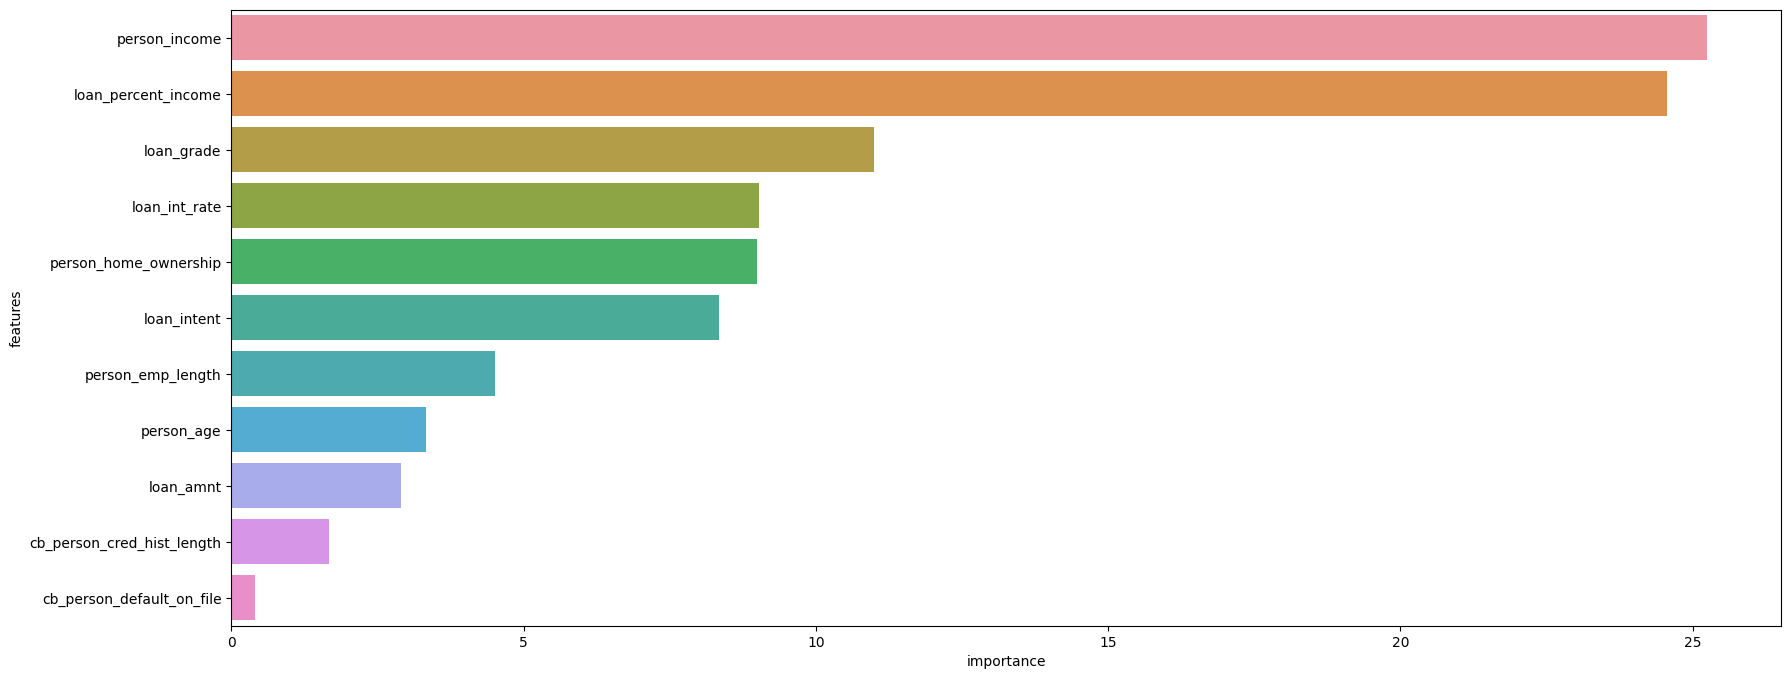

In [29]:
find_feature_importance_catboost(X_train, y_train, cat_features, optuna_model)

In [30]:
optuna_model_threshold = find_best_threshold(X_build, y_build, optuna_model)
print('Optimal threshold: ', model_threshold)

Optimal threshold:  0.67


In [31]:
# Evaluation of the deferred test sample
predictions = optuna_model.predict(X_test)
predictions_proba = optuna_model.predict_proba(X_test)[:, 1]
predictions = [1 if k >= optuna_model_threshold else 0 for k in predictions_proba]

print('Accuracy score: ', accuracy_score(predictions, y_test))
print('Recall score: ', recall_score(predictions, y_test))
print('Precision score: ', precision_score(predictions, y_test))
print('ROC-AUC score: ', roc_auc_score(y_test, predictions_proba))

Accuracy score:  0.9528275078147201
Recall score:  0.8665207877461707
Precision score:  0.7904191616766467
ROC-AUC score:  0.9593364629257058
